In [2]:
# Imports & Settings
from sklearn.neural_network import MLPClassifier as ANN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB as NB
from sklearn import svm as SVM
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DF = pd.read_csv("covid19_cleaned_8_10.zip", low_memory = False)

In [4]:
DF.columns

Index(['Unnamed: 0', 'ID', 'age', 'sex', 'city', 'province', 'country',
       'latitude', 'longitude', 'date_onset_symptoms',
       'date_admission_hospital', 'date_confirmation', 'symptoms',
       'travel_history_dates', 'travel_history_location',
       'reported_market_exposure', 'chronic_disease_binary', 'chronic_disease',
       'outcome', 'date_death_or_discharge', 'admin3', 'admin2', 'admin1',
       'travel_history_binary', 'hospitalized', 'deceased', 'fever', 'cough',
       'fatigue', 'headache', 'dizziness', 'sore throat', 'pneumonia',
       'respiratory', 'nausea', 'diarrhea', 'severe_r'],
      dtype='object')

In [5]:
# Neural net is refusing to run our machines--
# However, it does run when we use only half the data.
# Get the data training ready in this cell.

# Our working dataframe:
df_trimmed = DF

# Select only the columns we need.
df_trimmed = DF.loc[:, [
    "age",
    "chronic_disease_binary",
    "hospitalized",
    "deceased",
    "travel_history_binary",
    "sex",
    "country"
]]

# Drop the imputed age values.
# ugly...
df_trimmed = df_trimmed[np.logical_not(np.logical_and(DF["age"] >= 49.090200, DF["age"]<=49.091))]

# Turn ages into ints.
df_trimmed["age"].apply(int)

#boolify "sex"
df_trimmed.loc[:,"sex"] = [0 if s == "male" else 1 for s in df_trimmed["sex"]]

# Randomly select half of the data.
# (Thanks, Jorge.)
random50 = np.random.choice(np.arange(len(df_trimmed)), size=int(len(df_trimmed) / 2), replace=False)
df_trimmed = df_trimmed.iloc[random50,:]


# Now add in Gulnaz's dummies.
df_trimmed = pd.get_dummies(df_trimmed, columns=["country"])

In [291]:
# Run this cell to use only 10 percent of the data for testing functions.
random10 = np.random.choice(np.arange(len(df_trimmed)), size=int(len(df_trimmed) / 10), replace=False)
df_trimmed = df_trimmed.iloc[random10,:]


In [ ]:
# A peak at what some rows look like.
df_trimmed.head()

In [6]:
# How many rows we're working with.
len(df_trimmed)

156584

# Use of Data and Training

The nature of the data pointed us in the direction of classification. After cleaning the data, we had many boolean features. This led us to explore a few different classification models to see what we can predict. We extracted the countries columns into one-hot encoded features and used them to train our model, as well.

We ran into problems when trying to run the entire dataset through machine learning models. Because of this, we are training and fitting our models on half the data.  

The features we used are in the cell below. 

Though we had roughly 2 million rows to begin with, we use 156,584 rows here.

In [7]:
# Inspect the columns.
list(df_trimmed.columns)

['age',
 'chronic_disease_binary',
 'hospitalized',
 'deceased',
 'travel_history_binary',
 'sex',
 'country_Algeria',
 'country_Andorra',
 'country_Angola',
 'country_Argentina',
 'country_Australia',
 'country_Azerbaijan',
 'country_Bahamas',
 'country_Belgium',
 'country_Benin',
 'country_Bolivia',
 'country_Brazil',
 'country_Burkina Faso',
 'country_Cabo Verde',
 'country_Cameroon',
 'country_Canada',
 'country_Chile',
 'country_China',
 'country_Colombia',
 "country_Cote d'Ivoire",
 'country_Croatia',
 'country_Cuba',
 'country_Czech Republic',
 'country_Democratic Republic of the Congo',
 'country_Equatorial Guinea',
 'country_Estonia',
 'country_Eswatini',
 'country_Ethiopia',
 'country_Finland',
 'country_France',
 'country_Gambia',
 'country_Georgia',
 'country_Germany',
 'country_Ghana',
 'country_Greece',
 'country_Guatemala',
 'country_Guinea',
 'country_Guyana',
 'country_Iceland',
 'country_India',
 'country_Italy',
 'country_Japan',
 'country_Kazakhstan',
 'country_Keny

In [22]:
# We will train, test, and evaluate many different models
# Define a function that performs a single train test split on a model
# to avoid repeated code.
def tts(model, x, y):
    xtrain, xtest, ytrain, ytest = train_test_split(x, y)
    model.fit(xtrain, ytrain)
    yp = model.predict(xtest)
    probs = model.predict_proba(xtest)
    acc = accuracy_score(ytest,yp)
    return ytest, probs, acc

In [23]:
# Simple ROC curve on two features.
# predict y from x.
def rocFromCol(model, x, y, label):
    ytest, prob, acc = tts(model, x, y)
    fpr, tpr, thresh = roc_curve(ytest, prob[:,1])
    plt.plot(fpr, tpr, c=np.random.rand(3,), label=label)
    plt.plot([0,1],[0,1],c="k",ls="--")
    plt.gcf().set_size_inches(6,6) 
    plt.xlabel("False Positive Rate",fontsize=14)
    plt.ylabel("True Positive Rate",fontsize=14)
    plt.grid()
    plt.legend()
    return plt.gcf()

In [24]:
# Plot ROC curves that predict
# one feature from the dataframe
# from all of the other features in the dataframe.
def rocAllCols(model, df, ls):
    for col in ls:
        x = np.array(df.drop(col, axis=1))
        y = np.array(df[col].values)
        ytest, prob, acc = tts(model, x, y)
        fpr, tpr, thresh = roc_curve(ytest, prob[:,1])
        plt.plot(fpr, tpr, c=np.random.rand(3,), label=col)
    plt.plot([0,1],[0,1],c="k",ls="--")
    plt.gcf().set_size_inches(6,6) 
    plt.xlabel("False Positive Rate",fontsize=14)
    plt.ylabel("True Positive Rate",fontsize=14)
    plt.grid()
    plt.legend()
    return plt.gcf()

In [7]:
# Artificial Neural Network
ann = ANN(hidden_layer_sizes=(16,8,4), max_iter=1000)

# Support Vector Classifier
svm = SVM.SVC()

# Logistic Regression
lr = LR(max_iter=1000)

# Naive bayes
nb = NB()

In [12]:
# sex variables
x_sex = df_trimmed.drop("sex", axis=1)
y_sex = df_trimmed["sex"]

In [13]:
ann_sex_scores = cross_val_score(ann, x_sex, y_sex, cv=5, scoring="accuracy")

In [15]:
ann_sex_scores

array([0.55902545, 0.5580675 , 0.56790242, 0.561101  , 0.56389705])

In [368]:
# Perform a single train/test split. Keep values for our ROC curve later.
ytest_sex, p_sex, acc_sex = tts(ann, x_sex, y_sex)

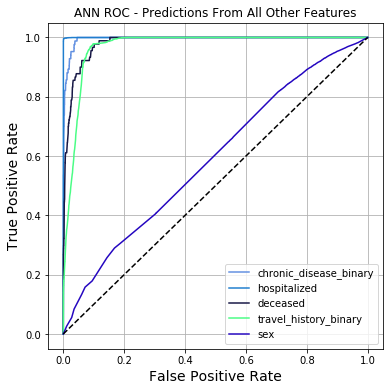

In [380]:
# On just ANN, Show an ROC curve for all features
# as predicted by all other features
fig = rocAllCols(ann, df_trimmed, trainingLabels)
plt.title("ANN ROC - Predictions From All Other Features")
plt.show()

In [17]:
# ANN - Predicting Deceased
x_deceased = df_trimmed.drop("deceased", axis=1)
y_deceased = df_trimmed["deceased"]

In [18]:
deceased_scores_ann = cross_val_score(ann, x_deceased, y_deceased, cv=5, scoring="accuracy")

In [19]:
deceased_scores_svm = cross_val_score(svm, x_deceased, y_deceased, cv=5, scoring="accuracy")

In [20]:
deceased_scores_lr = cross_val_score(lr, x_deceased, y_deceased, cv=5, scoring="accuracy")

In [21]:
deceased_scores_nb = cross_val_score(nb, x_deceased, y_deceased, cv=5, scoring="accuracy")

In [25]:
deceased_scores_ann, deceased_scores_svm, deceased_scores_lr, deceased_scores_nb

(array([0.99853115, 0.99808411, 0.99853115, 0.99808411, 0.99859497]),
 array([0.99811604, 0.99808411, 0.99808411, 0.99808411, 0.99811598]),
 array([0.99853115, 0.99853115, 0.99840342, 0.99833956, 0.9985311 ]),
 array([0.87297634, 0.8784047 , 0.87246543, 0.87527541, 0.87418572]))

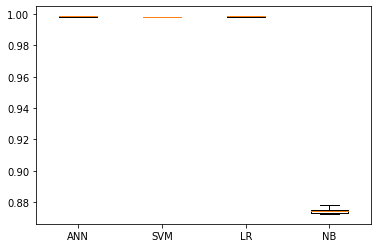

In [24]:
_ = plt.boxplot([
    deceased_scores_ann,
    deceased_scores_svm,
    deceased_scores_lr,
    deceased_scores_nb,
    ],
    labels = [
        "ANN",
        "SVM",
        "LR",
        "NB"
    ]
)

In [88]:
# Perform a single train/test split on deceased. Keep values for our ROC curve later.
ytest_deceased, p_deceased, acc_deceased = tts(ann, x_deceased, y_deceased)

In [9]:
# ANN - Predicting Hospitalizations
x_hosp = df_trimmed.drop("hospitalized", axis=1)
y_hosp = df_trimmed["hospitalized"]

In [13]:
hosp_scores_ann = cross_val_score(ann, x_hosp, y_hosp, cv=5, scoring="accuracy")

In [ ]:
# Can't get this to finish running...
hosp_scores_svm = cross_val_score(svm, x_hosp, y_hosp, cv=5, scoring="accuracy")

In [14]:
hosp_score_lr = cross_val_score(lr, x_hosp, y_hosp, cv=5, scoring="accuracy")

In [15]:
hosp_scores_nb = cross_val_score(nb, x_hosp, y_hosp, cv=5, scoring="accuracy")

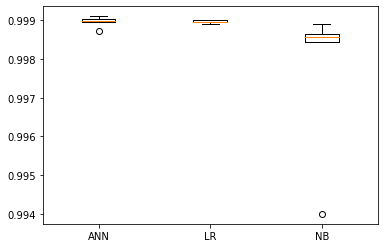

In [18]:
_ = plt.boxplot([
    hosp_scores_ann,
    hosp_score_lr,
    hosp_scores_nb,
    ],
    labels = [
        "ANN",
        "LR",
        "NB"
    ]
)

In [90]:
# Perform a single train/test split on hospitalizations. Keep values for our ROC curve later.
ytest_hosp, p_hosp, acc_hosp = tts(ann, x_hosp, y_hosp)

In [20]:
# Look at how individual features
# Predict hospitalizations and deaths.

#These are the features we will examine as predictors.
predictorLabels = [
    "chronic_disease_binary",
    "hospitalized",
    "deceased",
    "travel_history_binary",
    "sex",    
]

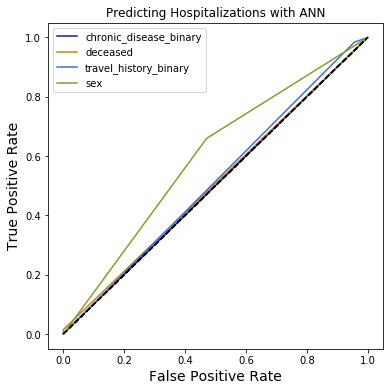

In [25]:
figs = []
for label in predictorLabels:
    if label != "hospitalized":
        x = df_trimmed[label].values.reshape(-1, 1)
        y = df_trimmed["hospitalized"].values
        figs.append(rocFromCol(ann, x, y, label))
plt.title("Predicting Hospitalizations with ANN")
plt.show()


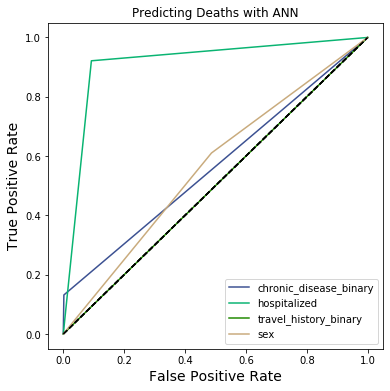

In [26]:
figs = []
for label in predictorLabels:
    if label != "deceased":
        x = df_trimmed[label].values.reshape(-1, 1)
        y = df_trimmed["deceased"].values
        figs.append(rocFromCol(ann, x, y, label))
plt.title("Predicting Deaths with ANN")
plt.show()